# An-Cockrell model reimplementation



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import itertools
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import an_cockrell

In [2]:
%matplotlib inline

In [3]:
model = an_cockrell.AnCockrellModel(
    GRID_WIDTH=50,
    GRID_HEIGHT=50,
    is_bat=False,
    init_dcs=50,
    init_macros=50,
    init_nks=25,
)

* Blue Squares = Healthy Epithelial Cells
* Yellow Squares = Infected Epithelial Cells
* Grey Squares = Epithelial Cells killed by necrosis
* Grey Pentagons = Epithelial Cells killed by apoptosis
* Green Circles = Macrophages
* Large Green Circles = Macrophages at phagocytosis limit
* Orange Circles = NK Cells
* Light Blue Triangles = Dendritic Cells
* Pink Square Outlines = Activated Endothelial Cells
* Small White Circles = PMNs

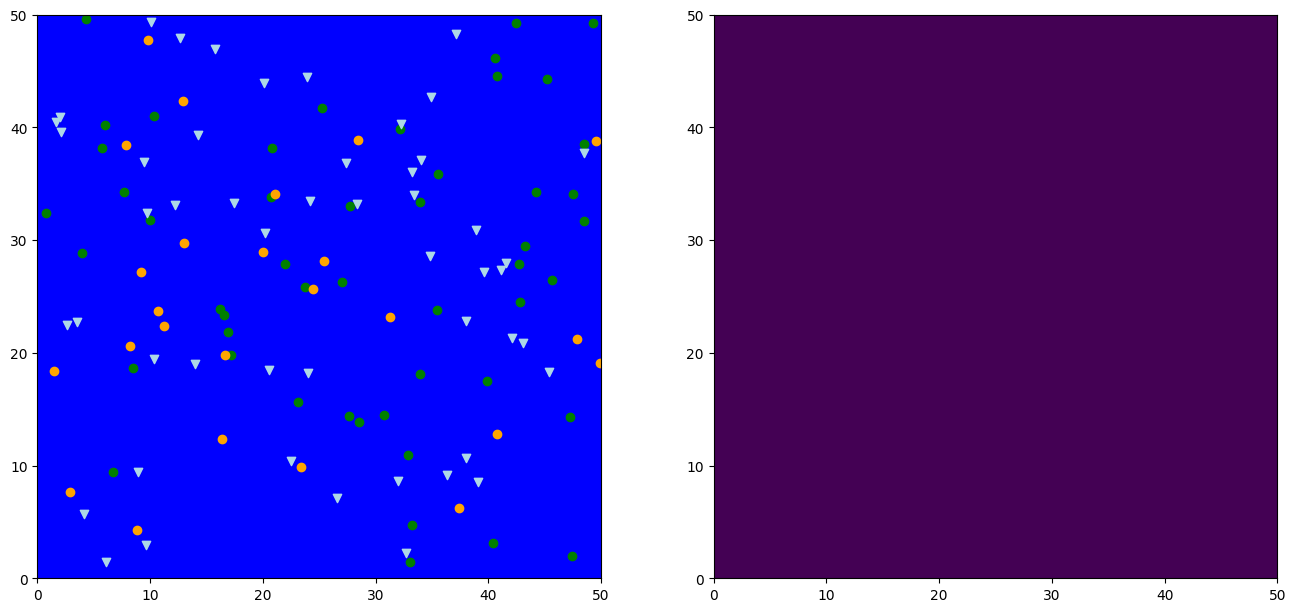

In [4]:

fig, axs = plt.subplots(1, 2,figsize=(16,8))

model.plot_agents(axs[0])
model.plot_field(axs[1], field_name='extracellular_virus')


axs[0].set_aspect(1)
axs[1].set_aspect(1)

In [5]:
model.infect(init_inoculum=150) # Initial-inoculum from 25-150 increments of 25, run for 14 days (2016 steps)

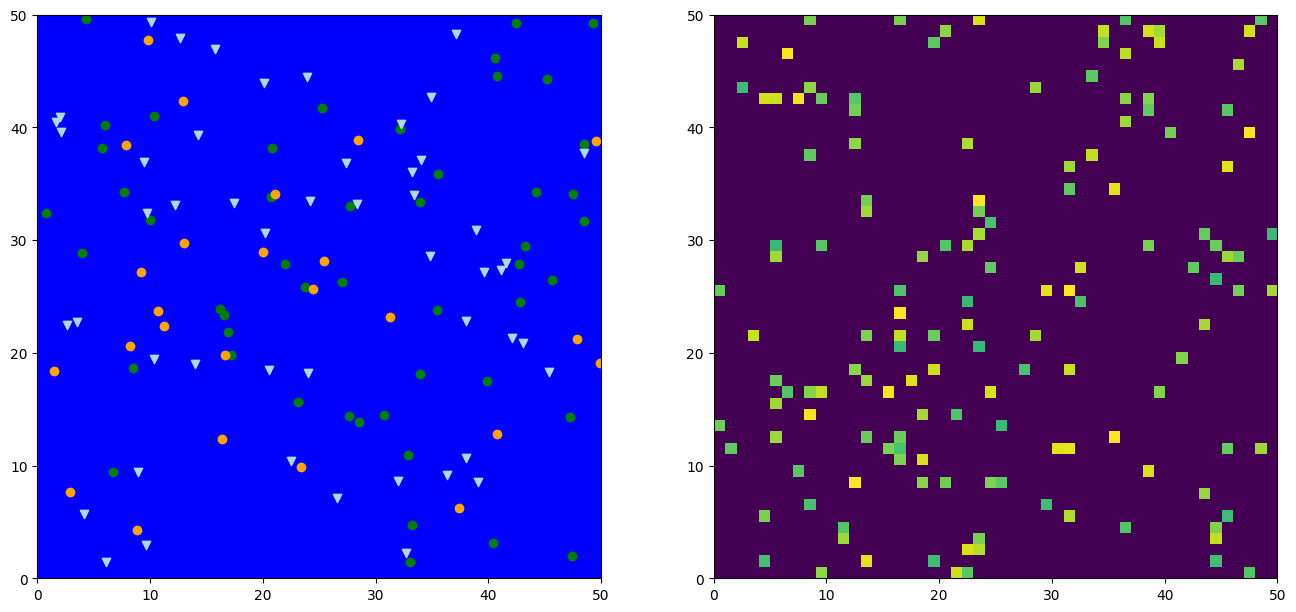

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(16,8))

model.plot_agents(axs[0])
model.plot_field(axs[1], field_name='extracellular_virus')


axs[0].set_aspect(1)
axs[1].set_aspect(1)

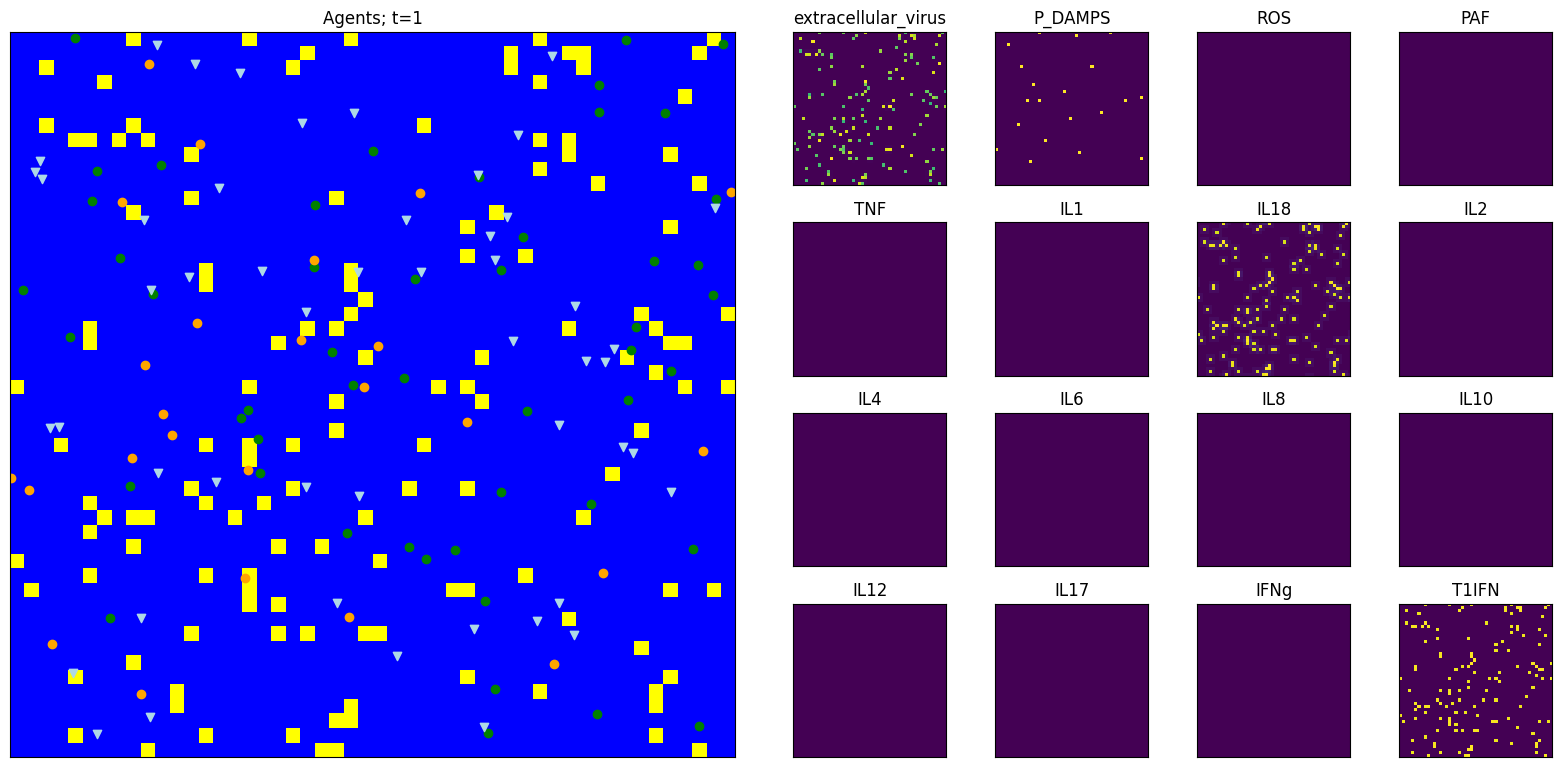

In [7]:
num_steps = 2016


fig = plt.figure(layout='constrained', figsize=(16, 8))
fig.set_tight_layout(True)

subfigs = fig.subfigures(1, 2, wspace=0.07)

ax = subfigs[0].add_subplot()
axs = subfigs[1].subplots(4, 4)

fields = [
    'extracellular_virus',
    'P_DAMPS',
    'ROS',
    'PAF',
    'TNF',
    'IL1',
    'IL18',
    'IL2',
    'IL4',
    'IL6',
    'IL8',
    'IL10',
    'IL12',
    'IL17',
    'IFNg',
    'T1IFN',
]

def animate(i):
    model.time_step()

    model.plot_agents(ax)
    ax.set_title(f'Agents; t={model.time}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_aspect(1)
    
    for k, field in enumerate(fields):
        model.plot_field(axs[k // 4, k % 4], field_name=field)
        axs[k//4, k%4].set_title(field)
        axs[k//4, k%4].get_xaxis().set_visible(False)
        axs[k//4, k%4].get_yaxis().set_visible(False)
        axs[k//4, k%4].set_aspect(1)
    

anim = FuncAnimation(fig, animate, frames=num_steps, repeat=False)

In [8]:
#HTML(anim.to_html5_video())

In [ ]:
anim.save('model-run.mpg')